In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream,params
import numpy as np
import matplotlib.pyplot as plt
import pandas

In [2]:
descriptors = loading.get_descriptors()
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
mdx_full = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)
mdx_drag_morg = dream.get_molecular_data(['dragon','morgan'],all_CIDs)
mdx_drag = dream.get_molecular_data(['dragon'],all_CIDs)

Episuite has 62 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
NSPDK has 6163 features for 476 molecules.
NSPDK Gramian has 2437 features for 476 molecules.
There are now 15969 total features.
Morgan has 2437 features for 476 molecules.
There are now 7307 total features.
There are now 4870 total features.


In [3]:
# Create the feature matrices from the feature dicts.  
from sklearn.preprocessing import Imputer,MinMaxScaler
#X_all,good1,good2,means,stds,imputer = dream.make_X(mdx_full,['training','leaderboard'])
X_drag,good1,good2,means,stds,imputer = dream.make_X(mdx_drag,['training','leaderboard'])
X_drag_morg,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,['training','leaderboard'])
def quad_prep(mdx):
    X_temp,_,_,_,_,_ = dream.make_X(mdx,['training','leaderboard'],raw=True)
    X_temp[np.isnan(X_temp)] = 0     
    X_scaled = MinMaxScaler().fit_transform(X_temp[:,:-2])
    X_scaled_sq = np.hstack((X_scaled,X_scaled**2,X_temp[:,-2:]))
    return X_scaled_sq
X_drag_sq = quad_prep(mdx_drag)
X_drag_morg_sq = quad_prep(mdx_drag_morg)
Y_all,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

The X matrix now has shape (814x3063) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x5497) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x4871) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x7308) molecules by non-NaN good molecular descriptors
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [4]:
codes = ['Intensity',
'Valence/pleasantness',
'Bakery',
'swEet',
'fRuit',
'Fish',
'garLic',
'sPices',
'Cold',
'Sour',
'burNt',
'Acid',
'Warm',
'musKy',
'sweaTy',
'ammonia/Urinous',
'decaYed',
'wooD',
'Grass',
'flOwer',
'cheMical']
letters = [[x for x in code if (x.upper() == x and x!='/') ][0] for code in codes]
print(len(set(letters)))

21


## Figure 4: How many features

In [5]:
import pandas as pd
linear_mean_noleak = pd.read_csv('../../data/2e_mean_noleak.csv')
linear_mean_wleak = pd.read_csv('../../data/2e_mean_wleak.csv')
linear_sem_noleak = pd.read_csv('../../data/2e_se_noleak.csv')
linear_sem_wleak = pd.read_csv('../../data/2e_se_wleak.csv')

In [685]:
lin_importances = np.zeros((10,21,14613)) # 10 splits, 21 descriptors, 14613 features without the leak (7606*2 + negLogD)
lin_ranked = np.zeros((10,21,14613)).astype(int) # Matrix to store the score rankings.  
lin_features = pd.read_csv('../../data/linear_scores_and_features/features_dragon_morgan.csv',nrows=0)
for split in range(10):
    for desc in range(21):
        scores = pd.read_csv('../../data/linear_scores_and_features/LB_scores_morgan%d/scores_%d.csv' % (split,desc),index_col=0)
        scores.drop(['0','Intensity'],inplace=1) # Get rid of that weird "0" feature and the leak feature.  
        scores['int'] = np.arange(14613).astype(int) # Temp index to use for ranking.  
        lin_ranked[split,desc,:] = scores.sort_values(by='0',ascending=0)['int'] # Sort and store the ranking.  

In [686]:
lin_ranked[0,0,:] # The feature ranking for the first split, for intensity. 
                  # negLogD appears first, so presumably this is working.  

array([14612,  5847, 13011, ...,  5085,  5088,  7306])

In [288]:
from scipy.interpolate import interp1d
kinds = ['rf','lin','tot','ratio','diff']
maxx = {}
maxloc = {}
threshes = [99]
for kind in kinds:
    maxx[kind] = np.zeros(21)
    maxloc[kind] = {}
    for thresh in threshes:
        maxloc[kind][thresh] = np.zeros(21)

In [347]:
"""
lin_importances = np.zeros((10,21,7307))
lin_ranked = np.zeros((10,21,7307))
lin_features = pd.read_csv('../../data/linear_scores_and_features/features_dragon_morgan.csv',nrows=0)
for split in range(10):
    for desc in range(21):
        scores = pd.read_csv('../../data/linear_scores_and_features/LB_scores_morgan%d/scores_%d.csv' % (split,desc),index_col=0)
        scores.drop(['0','Intensity'],inplace=1)
        #print(scores.tail())
        a = [x for x in scores.index.values if '_2_2' in x]
        b = [x for x in scores.index.values if '_2' in x and x+'_2' not in a]
        new_indices = [x[:-2] if x in b else x for x in scores.index.values]
        scores['index'] = np.arange(len(scores))
        scores.index = new_indices #set the new indices
        grouped = scores.groupby(level=0).max() #group the rows with the same name with max function
        grouped.sort_values(by='index',inplace=True)
        grouped['index'] = np.arange(len(grouped))
        feature_number = 10
        grouped.sort_values(by='0',ascending=0,inplace=1)
        selected = grouped[:feature_number]
        lin_ranked[split,desc,:] = grouped['index'].as_matrix()
""";

In [348]:
"""lin_features = pd.read_csv('../../data/linear_scores_and_features/features_dragon_morgan.csv',nrows=0)
lin_features = list(lin_features)[2:] # Remove index and CID
n_dragon = 7307-2438
n_morgan = 2437
keep = list(range(n_dragon)) + list(range(2*n_dragon+1,2*n_dragon+1+n_morgan)) + [len(lin_features)-1]
keep2 = list(range(n_dragon,2*n_dragon)) + list(range(2*n_dragon+1+n_morgan,2*n_dragon+1+2*n_morgan)) + [len(lin_features)-1]
lin_features = [f for i,f in enumerate(lin_features) if i in keep]

mdx_linear = dream.get_molecular_data(['dragon','morgan'],all_CIDs)
#X_lin,good1,good2,_,_,_ = dream.make_X(mdx_linear,['training','leaderboard'])
X_lin,_,_,_,_,_ = dream.make_X(mdx_linear,['training','leaderboard'],good1=range(len(keep)),good2=range(len(keep)))
#X_lin = X_lin[:,:-1] # Remove leak feature
#good = np.array(good1)[good2]
#good = good[:-1] # Remove leak feature
#bad = list(set(list(range(len(keep)))).difference(good))

lin_importances = np.zeros((10,21,len(keep)))
lin_ranked = np.zeros((10,21,len(keep)))
#lin_importances = np.zeros((10,21,len(good)))
#lin_ranked = np.zeros((10,21,len(good)))
for split in range(10):
    for desc in range(21):
        x = pd.read_csv('../../data/linear_scores_and_features/LB_scores_morgan%d/scores_%d.csv' % (split,desc))
        weights = x['0'].as_matrix()
        weights = weights[keep]# + weights[keep2] # Add linear and quadratic terms
        #weights[-1] /= 2 # Only count the dilution feature once.  
        #weights = weights[good]
        #weights[bad] = -1
        lin_importances[split,desc,:] = weights
        lin_ranked[split,desc,:] = sorted(range(len(weights)),key=lambda x:weights[x],reverse=True)
""";

In [6]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.linear_model import Ridge

n_features = [1,2,3,4,5,10,33,100,333,1000,3333,10000]
n_splits = 250

# This class produces a new iterator that makes sure that the training and test set do not contains the same molecule
# at different dilutions, and also that the higher concentration is tested (or 10^-3 for intensity).  
class DoubleSS:
    def __init__(self, ss, col, concs):
        self.splits = ss
        self.col = col
        self.concs = concs

    def __iter__(self):
        for train, test in self.splits:
            train = np.concatenate((2*train,2*train+1))
            if self.col>0:
                test = 2*test+1 # The second (higher) concentration of the pair
            else:
                test = np.concatenate((2*test,2*test+1))
                test = test[self.concs[test]==-3]
            yield train, test
            
    def __len__(self):
        return len(self.splits)

Y = Y_all['mean_std'] # Use the perceptual means (second 21 columns are std's which are ignored here)

In [7]:
trans_params = params.get_trans_params(Y_all, descriptors, plot=False)
use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()

In [8]:
def feature_sweep(X_all,Y,n_estimators,n_splits=n_splits,n_features=n_features,model='rf',alpha=1.0,rfe=False,random_state=0):
    global rs
    n_obs = int(X_all.shape[0]/2) # Number of molecules.  
    shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.17,random_state=0) # This will produce the splits in 
                                                                               # train/test_big that I put on GitHub
    
    for col in range(20,21): # For each descriptor.  
        X = X_all[:,:-1] # Remove high/low dilution feature, i.e. remove the leak.
        observed = Y[:,col] # Perceptual data for this descriptor.  
        n_features_ = list(np.array(n_features)+(col==0))
        cv = DoubleSS(shuffle_split, col, X_all[:,-2]) # Produce the correct train and test indices.  
        for j,(train,test) in enumerate(cv):
            print(col,j)
            if model == 'rf': # If the model is random forest regression.  
                if col==0:
                    est = ExtraTreesRegressor(n_estimators=n_estimators,max_features=max_features[col],max_depth=max_depth[col],
                                            min_samples_leaf=min_samples_leaf[col],oob_score=False,n_jobs=8,random_state=random_state)
                else:
                    est = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features[col],max_depth=max_depth[col],
                                            min_samples_leaf=min_samples_leaf[col],n_jobs=8,random_state=random_state)
                #if col==0:
                #    est = ExtraTreesRegressor(n_estimators=n_estimators,max_features='auto',oob_score=False,
                #                              n_jobs=8,random_state=random_state)
                #else:
                #    est = RandomForestRegressor(n_estimators=n_estimators,max_features='auto',
                #                                n_jobs=8,random_state=random_state)
            elif model == 'ridge': # If the model is ridge regression. 
                est = Ridge(alpha=alpha,fit_intercept=True, normalize=False, 
                            copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=random_state)
            if rfe:  
                rfe = RFE(estimator=est, step=n_features_, n_features_to_select=1)
                rfe.fit(X[train,:],observed[train])    
            else:  
                est.fit(X[train,:],observed[train]) # Fit the model on the training data.  
                if model == 'rf':
                    importance_ranks = np.argsort(est.feature_importances_)[::-1] # Use feature importances to get ranks.  
                elif model == 'ridge':
                    importance_ranks = lin_ranked[j,col,:] # Use the pre-computed ranks.
            for i,n_feat in enumerate(n_features_):
                if hasattr(est,'max_features') and est.max_features is not None:
                    if n_feat < max_features[col]:
                        est.max_features = None
                    else:
                        est.max_features = max_features[col]
                if rfe:
                    est.fit(X[train,:][:,rfe.ranking_<=(1+i)],observed[train])
                    predicted = est.predict(X[test,:][:,rfe.ranking_<=(1+i)])
                else:
                    est.fit(X[train,:][:,importance_ranks[:n_feat]],
                            observed[train]) # Fit the model on the training data with max_features features.
                    predicted = est.predict(X[test,:][:,importance_ranks[:n_feat]]) # Predict the test data.  
                rs[col,i,j] = np.corrcoef(predicted,observed[test])[1,0] # Compute the correlation coefficient. 
                
        means = rs[col,:,:].mean(axis=1)
        sems = rs[col,:,:].std(axis=1)/np.sqrt(n_splits)
        print(('Desc. %d:'+len(n_features)*' [%.3f],') % \
              tuple([col]+[means[i] for i in range(len(n_features))]))
    return rs

In [9]:
#rs = np.zeros((21,len(n_features),n_splits)) # Empty matrix to store correlations.  
rs_forest = feature_sweep(X_drag_morg,Y,50,n_splits=250,model='rf')

20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 13
20 14
20 15
20 16
20 17
20 18
20 19
20 20
20 21
20 22
20 23
20 24
20 25
20 26
20 27
20 28
20 29
20 30
20 31
20 32
20 33
20 34
20 35
20 36
20 37
20 38
20 39
20 40
20 41
20 42
20 43
20 44
20 45
20 46
20 47
20 48
20 49
20 50
20 51
20 52
20 53
20 54
20 55
20 56
20 57
20 58
20 59
20 60
20 61
20 62
20 63
20 64
20 65
20 66
20 67
20 68
20 69
20 70
20 71
20 72
20 73
20 74
20 75
20 76
20 77
20 78
20 79
20 80
20 81
20 82
20 83
20 84
20 85
20 86
20 87
20 88
20 89
20 90
20 91
20 92
20 93
20 94
20 95
20 96
20 97
20 98
20 99
20 100
20 101
20 102
20 103
20 104
20 105
20 106
20 107
20 108
20 109
20 110
20 111
20 112
20 113
20 114
20 115
20 116
20 117
20 118
20 119
20 120
20 121
20 122
20 123
20 124
20 125
20 126
20 127
20 128
20 129
20 130
20 131
20 132
20 133
20 134
20 135
20 136
20 137
20 138
20 139
20 140
20 141
20 142
20 143
20 144
20 145
20 146
20 147
20 148
20 149
20 150
20 151
20 152
20 153
20 154
20 155
20 156
20 157
20 1

In [12]:
np.save('../../data/forest_rs_250_10-14.npy',rs)

In [14]:
forest_noleak = np.load('../../data/forest_noleak.npy')
#rs = np.load('../../data/forest_leak.dat.npy')
#rs5 = np.load('../../data/forest_betterleak.dat.npy')

In [16]:
rs_lin = np.load('../../data/gabor_rs_250.npy')

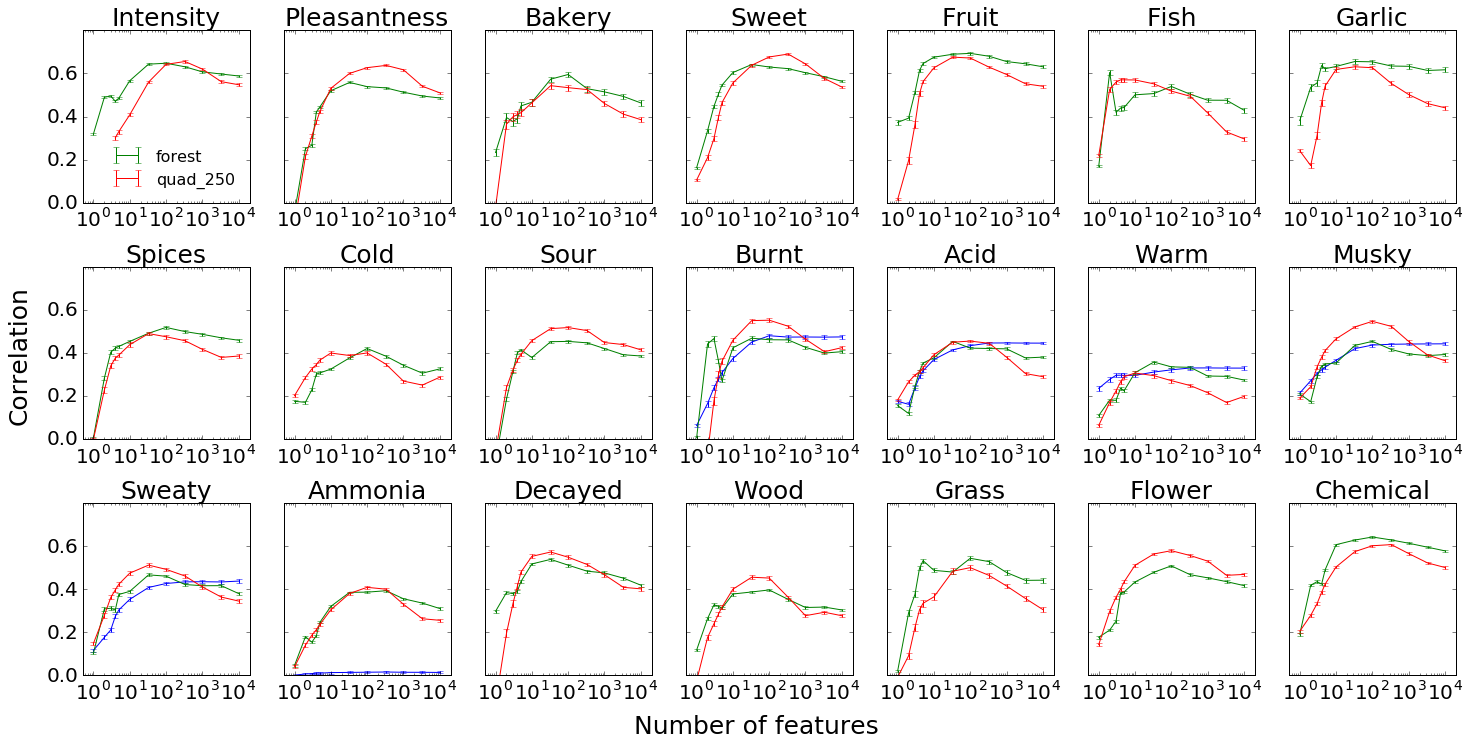

In [17]:
#assert np.array_equal(np.array(n_features),np.array(linear_mean_wleak['number of features']))
fig,axes = plt.subplots(3,7,sharex=False,sharey=True,figsize=(20,10))
for col,ax in enumerate(axes.flat):
    #rf_means = forest_noleak[col,:,:].mean(axis=1)
    #lin_means = linear_mean_noleak[descriptors[col]]
    #ax.errorbar(n_features,rf_means,forest_noleak[col,:,:].std(axis=1)/np.sqrt(n_splits),color='green',label='forest')
    #ax.errorbar(n_features,lin_means,linear_sem_noleak[descriptors[col]],color='purple',label='linear')
    #ax.errorbar(n_features,rs2[col].mean(axis=1),rs2[col].std(axis=1)/np.sqrt(n_splits),color='yellow',label='forest_250_old')
    ax.errorbar(n_features,rs[col].mean(axis=1),rs[col].std(axis=1)/np.sqrt(n_splits),color='blue',label='forest_250')
    ax.errorbar(n_features,forest_noleak[col].mean(axis=1),forest_noleak[col].std(axis=1)/np.sqrt(n_splits),color='green',label='forest')
    #ax.errorbar(n_features,rs7[col].mean(axis=1),rs7[col].std(axis=1)/np.sqrt(n_splits),color='green',label='forest')
    ax.errorbar(n_features,rs_lin[col].mean(axis=1),rs_lin[col].std(axis=1)/np.sqrt(n_splits),color='red',label='quad_250')
    #ax.errorbar(n_features,rs9[col].mean(axis=1),rs9[col].std(axis=1)/np.sqrt(n_splits),color='green',label='f30_sq')
    if col==0:
        handles, labels = ax.get_legend_handles_labels()
        lg = ax.legend(handles[1:], labels[1:], loc=4, fontsize=16)
        lg.draw_frame(False)
    
    #log_features = np.log10(n_features)
    #f = interp1d(log_features, rf_means, kind='cubic')
    #lfn = np.linspace(0, 4, num=21, endpoint=True) # Locations for interpolation.  
    #ax.plot(10**lfn,f(lfn),'--',color='blue')
    
    #log_features = np.log10(n_features)
    #f = interp1d(log_features, lin_means, kind='cubic')
    #lfn = np.linspace(0, 4, num=21, endpoint=True) # Locations for interpolation.  
    #ax.plot(10**lfn,f(lfn),'--',color='red')
    
    ax.set_xlim(0.5,20000)
    ax.set_ylim(0,0.8)
    ax.set_yticks(np.linspace(0,0.6,4))
    ax.set_yticklabels([_ for _ in np.linspace(0,0.6,4)],size=20)
    ax.set_xticklabels(n_features,size=20)
    ax.set_xscale('log')
    descriptor = descriptors[col].split('/')[1 if col==1 else 0]
    descriptor = descriptor[0]+descriptor[1:].lower()
    ax.set_title(descriptor, size=25)
plt.tight_layout()
fig.text(0.5, -0.025, 'Number of features', ha='center', size=25)
fig.text(-0.02, 0.5, 'Correlation', va='center', rotation='vertical', size=25);

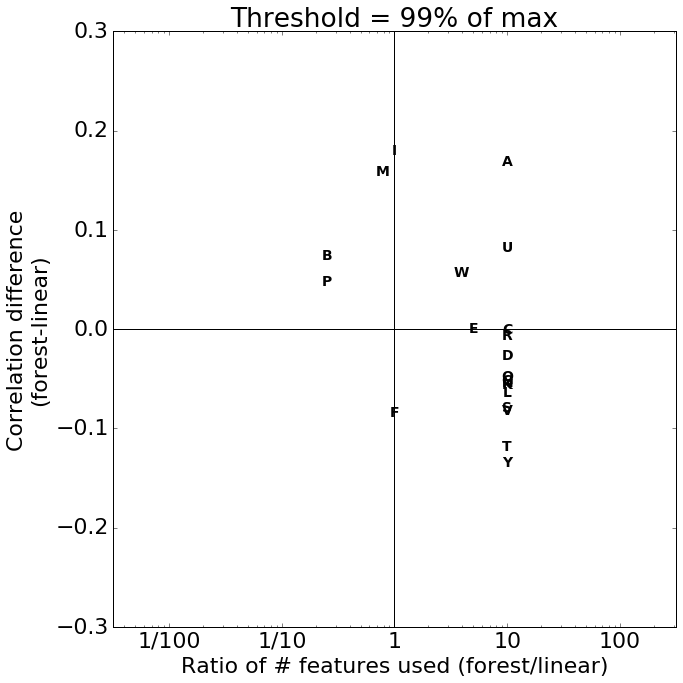

In [291]:
fig,axes = plt.subplots(len(threshes),1,figsize=(10,10),squeeze=False)
for i,thresh in enumerate(threshes):
    axes[i,0].scatter(maxloc['ratio'][thresh],maxx['diff'],s=0)
    axes[i,0].plot([1,1],[-0.3,0.3],'k')
    axes[i,0].plot([3.16e-3,3.16e2],[0,0],'k')
    axes[i,0].set_xscale('log')
    axes[i,0].set_xticks(np.logspace(-2,2,5))
    axes[i,0].set_xticklabels(['1/100','1/10','1','10','100'])
    axes[i,0].set_xlim(3.16e-3,3.16e2)
    axes[i,0].set_ylim(-0.3,0.3)
    axes[i,0].set_xlabel('Ratio of # features used (forest/linear)')
    axes[i,0].set_ylabel('Correlation difference\n(forest-linear)')
    axes[i,0].set_title('Threshold = %d%% of max' % threshes[i])
    for j in range(21):
        axes[i,0].text(np.clip(maxloc['ratio'][thresh][j],0.1,10),maxx['diff'][j],letters[j],fontdict={'size':14,'weight':'bold'},horizontalalignment='center',verticalalignment='center')
    
plt.tight_layout()

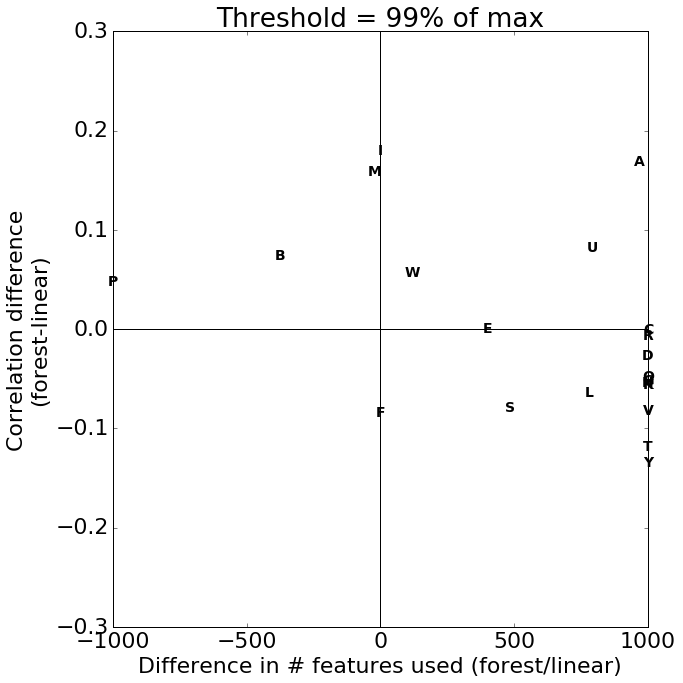

In [292]:
fig,axes = plt.subplots(len(threshes),1,figsize=(10,10),squeeze=False)
for i,thresh in enumerate(threshes):
    axes[i,0].scatter(maxloc['diff'][thresh],maxx['diff'],s=0)
    axes[i,0].plot([0,0],[-0.3,0.3],'k')
    axes[i,0].plot([-5000,5000],[0,0],'k')
    axes[i,0].set_ylim(-0.3,0.3)
    axes[i,0].set_xlabel('Difference in # features used (forest/linear)')
    axes[i,0].set_ylabel('Correlation difference\n(forest-linear)')
    axes[i,0].set_title('Threshold = %d%% of max' % threshes[i])
    for j in range(21):
        clip = {100:1000,99:1000,95:250,90:50}
        axes[i,0].text(np.clip(maxloc['diff'][thresh][j],-clip[thresh],clip[thresh]),maxx['diff'][j],letters[j],fontdict={'size':14,'weight':'bold'},horizontalalignment='center',verticalalignment='center')
    axes[i,0].set_xlim(-clip[thresh],clip[thresh])
plt.tight_layout()

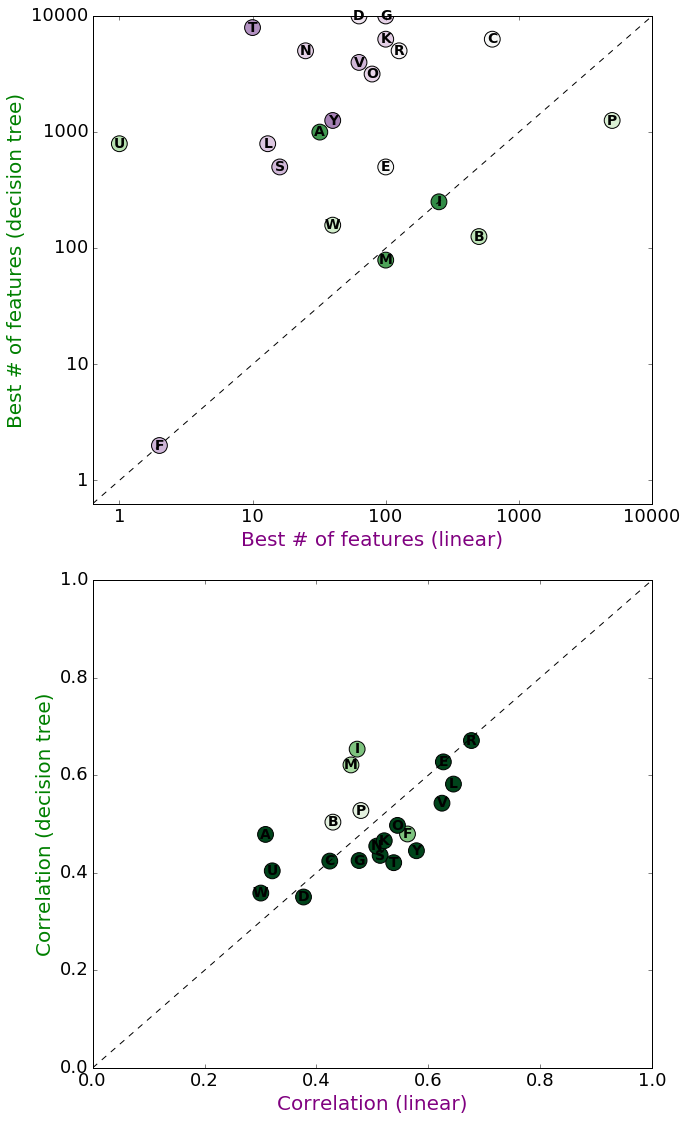

In [293]:
fig,axes = plt.subplots(2,len(threshes),figsize=(10,16),squeeze=False)
for i,thresh in enumerate(threshes):
    axes[0,i].scatter(np.log10(maxloc['lin'][thresh]),np.log10(maxloc['rf'][thresh]),cmap='PRGn',vmax=0.25,vmin=-0.25,c=maxx['diff'],s=250,zorder=0)
    axes[1,i].scatter(maxx['lin'],maxx['rf'],cmap='PRGn',vmax=2,vmin=-2,c=maxloc['ratio'][thresh],s=250,zorder=0)
    axes[0,i].plot([-0.2,4],[-0.2,4],'--',color='k')
    axes[1,i].plot([0,1],[0,1],'--',color='k')
    axes[0,i].set_xlim(-0.2,4)
    axes[0,i].set_ylim(-0.2,4)
    axes[1,i].set_xlim(0,1)
    axes[1,i].set_ylim(0,1)
    ticks = [0,1,2,3,4]
    axes[0,i].set_xticks(ticks)
    axes[0,i].set_xticklabels([10**tick for tick in ticks],fontsize=18)
    axes[0,i].set_yticks(ticks)
    axes[0,i].set_yticklabels([10**tick for tick in ticks],fontsize=18)
    ticks = np.linspace(0,1,6)
    axes[1,i].set_xticks(ticks)
    axes[1,i].set_xticklabels(ticks,fontsize=18)
    axes[1,i].set_yticks(ticks)
    axes[1,i].set_yticklabels(ticks,fontsize=18)
    axes[0,i].set_xlabel('Best # of features (linear)',fontsize=20,color='purple')
    axes[0,i].set_ylabel('Best # of features (decision tree)',fontsize=20,color='green');
    axes[1,i].set_xlabel('Correlation (linear)',fontsize=20,color='purple')
    axes[1,i].set_ylabel('Correlation (decision tree)',fontsize=20,color='green');
    for j in range(21):
        axes[0,i].text(np.log10(maxloc['lin'][thresh][j]),np.log10(maxloc['rf'][thresh][j]),letters[j],fontdict={'size':14,'weight':'bold'},horizontalalignment='center',verticalalignment='center')
        axes[1,i].text(maxx['lin'][j],maxx['rf'][j],letters[j],fontdict={'size':14,'weight':'bold'},horizontalalignment='center',verticalalignment='center')
plt.tight_layout()

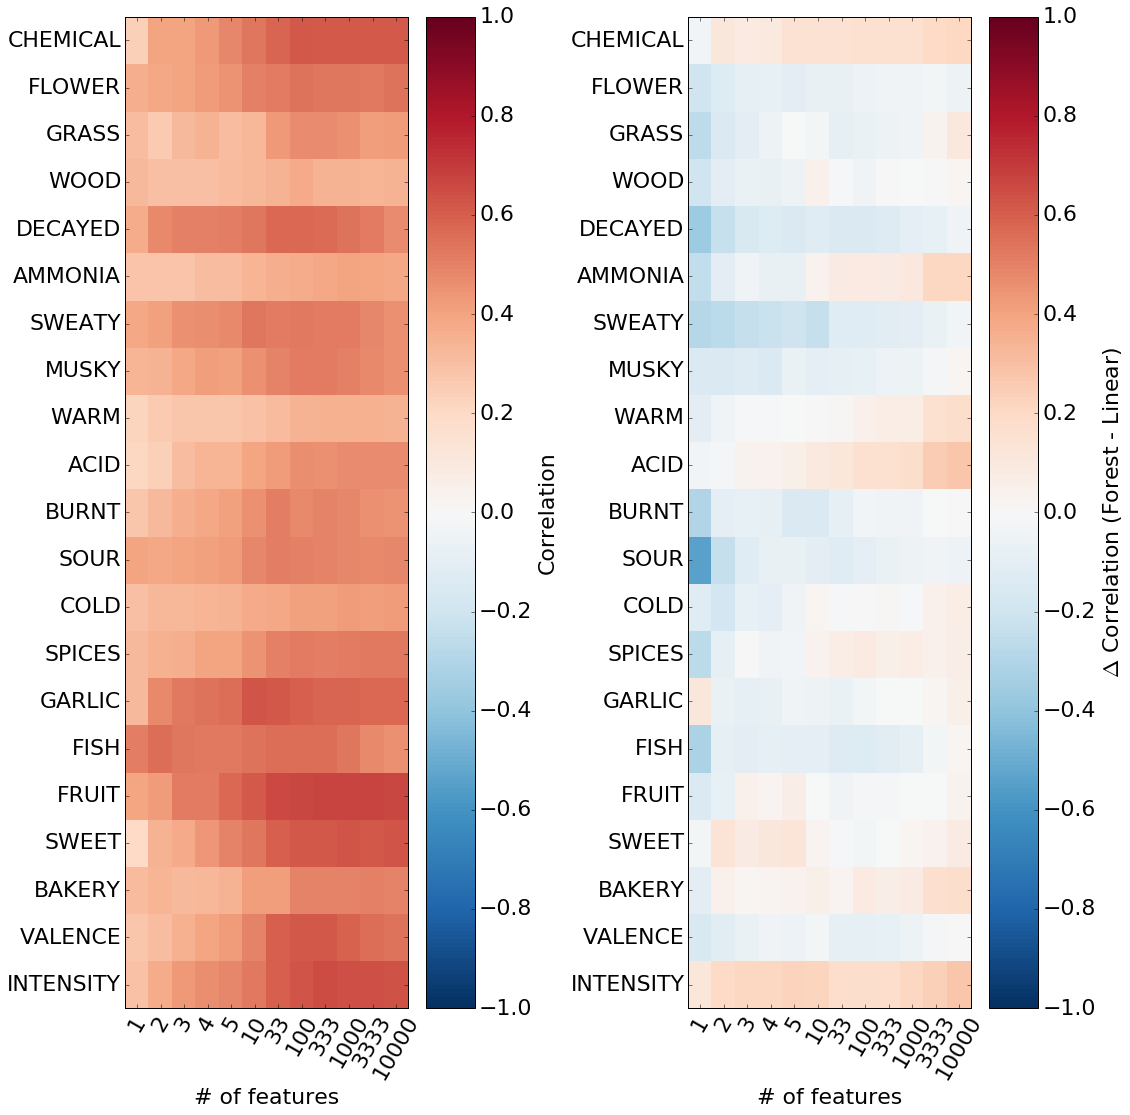

In [294]:
forest_corr = np.zeros((len(n_features),21))
lin_corr = np.zeros((len(n_features),21))
for i in range(21):
    forest_corr[:,i] = forest_noleak[i,:,:].mean(axis=1)
    lin_corr[:,i] = linear_mean_noleak[descriptors[i]]
total_corr = np.maximum(forest_corr,lin_corr)
diff_corr = forest_corr - lin_corr
fig,axes = plt.subplots(1,2,figsize=(16,16))
for i,corr in enumerate([total_corr,diff_corr]):
    ax = axes.flat[i]
    im = ax.pcolor(corr.T,cmap='RdBu_r',vmin=-1,vmax=1)            
    ax.set_yticks(np.arange(0.5,21.5))
    ax.set_yticklabels([d.split('/')[0] for d in descriptors],rotation=0)
    ax.set_ylim(0,21)
    ax.set_xticks(np.arange(0.5,12.5))
    ax.set_xticklabels(n_features,rotation=60)
    ax.set_xlabel('# of features')
    ax2 = plt.colorbar(im,ax=ax)
    ax2.set_label('Correlation' if i<1 else '$\Delta$ Correlation (Forest - Linear)')
plt.tight_layout()

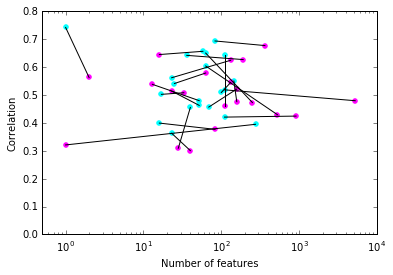

In [29]:
from scipy.interpolate import interp1d
rf_max,rf_maxloc,lin_max,lin_maxloc = [np.zeros(21) for _ in range(4)]
for col,desc in enumerate(descriptors):
    rf_means = rs2[col,:,:].mean(axis=1)
    lin_means = linear_mean_noleak[descriptors[col]]
    
    log_features = np.log10(n_features)
    f = interp1d(log_features, rf_means, kind='cubic')
    lfn = np.linspace(0, 4, num=101, endpoint=True) # Locations for interpolation.  
    rf_max[col] = f(lfn).max()
    rf_maxloc[col] = int(round(10**(lfn[f(lfn).argmax()])))
    
    f = interp1d(log_features, lin_means, kind='cubic')
    lin_max[col] = f(lfn).max()
    lin_maxloc[col] = int(round(10**(lfn[f(lfn).argmax()])))
    
    plt.plot((rf_maxloc[col],lin_maxloc[col]),(rf_max[col],lin_max[col]),color='k')
plt.scatter(rf_maxloc,rf_max,color='cyan')
plt.scatter(lin_maxloc,lin_max,color='magenta')
plt.xscale('log')
plt.xlim(0.5,10000)
plt.ylim(0,0.8)
plt.xlabel('Number of features')
plt.ylabel('Correlation');

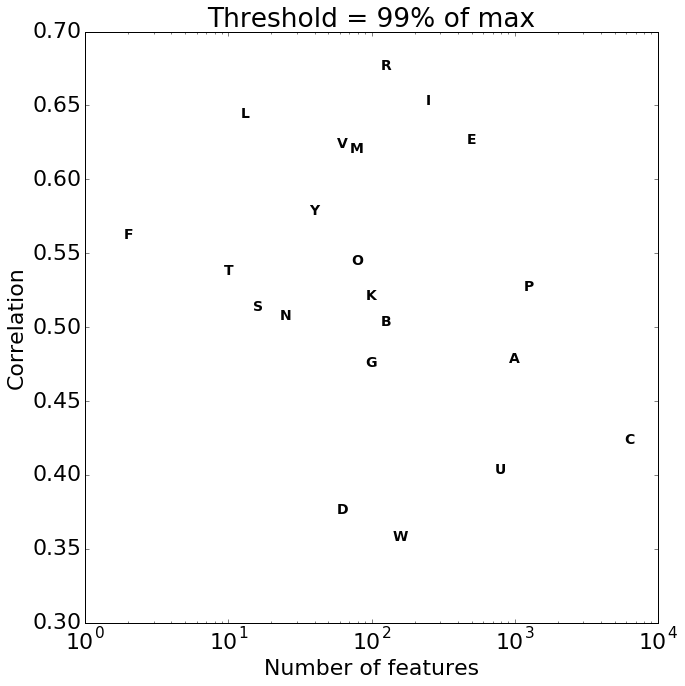

In [290]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})
fig,axes = plt.subplots(len(threshes),1,figsize=(10,10),squeeze=False)
for i,thresh in enumerate(threshes):
    axes[i,0].scatter(maxloc['tot'][thresh],maxx['tot'],s=0)
    axes[i,0].set_xlabel('Number of features')
    axes[i,0].set_ylabel('Correlation')
    for j in range(21):
        axes[i,0].text(maxloc['tot'][thresh][j],maxx['tot'][j],letters[j],fontdict={'size':14,'weight':'bold'},horizontalalignment='center',verticalalignment='center')
    axes[i,0].set_title('Threshold = %d%% of max' % thresh)
    axes[i,0].set_xscale('log')

plt.tight_layout()

In [289]:
for col,desc in enumerate(descriptors):
    means = {}
    means['rf'] = forest_noleak[col,:,:].mean(axis=1)
    means['lin'] = linear_mean_noleak[descriptors[col]]
    
    lfn = np.linspace(0, 4, num=41, endpoint=True) # Locations for interpolation.  
    log_features = np.log10(n_features)
    f = {}
    for model in ['rf','lin']:
        f[model] = interp1d(log_features, means[model], kind='cubic')
        maxx[model][col] = f[model](lfn).max()
    maxx['tot'][col] = max(maxx['rf'][col],maxx['lin'][col])
    
    for thresh in threshes:
        for model in ['rf','lin']:
            try:
                index = list(f[model](lfn) >= (0.01 * thresh * maxx['tot'][col])).index(1)
            except:
                index = np.argmax(f[model](lfn))
                maxloc[model][thresh][col] = int(round(10**lfn[index])) 
            else:
                maxloc[model][thresh][col] = int(round(10**lfn[index]))
            
        maxloc['tot'][thresh][col] = maxloc['rf'][thresh][col] if (maxx['rf'][col] >= maxx['lin'][col]) else maxloc['lin'][thresh][col]

maxx['diff'] = maxx['rf'] - maxx['lin']
for thresh in threshes:
    maxloc['diff'][thresh] = maxloc['rf'][thresh] - maxloc['lin'][thresh]
    maxloc['ratio'][thresh] = maxloc['rf'][thresh] / maxloc['lin'][thresh]

## Fig. 5a: With or without Morgan Fingerprints

In [719]:
def master_cv(X_all,Y,n_estimators,n_splits=50,model='rfc',alpha=1.0,random_state=0):
    rs = np.zeros((21,n_splits))
    n_obs = int(X_all.shape[0]/2)
    shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.17,random_state=0) # This random state *must* be zero.  
    
    for col in range(21):
        print(col)
        X = X_all[:,:-1] # Remove high/low dilution feature.
        observed = Y[:,col]
        n_features_ = list(np.array(n_features)+(col==0))
        cv = DoubleSS(shuffle_split, col, X_all[:,-2])
        for j,(train,test) in enumerate(cv):
            print(col,j)
            if model == 'rfc':
                if col==0:
                    est = ExtraTreesRegressor(n_estimators=n_estimators,max_features=max_features[col], max_depth=max_depth[col], 
                                            min_samples_leaf=min_samples_leaf[col],
                                            n_jobs=8,random_state=0)     
                else:
                    est = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features[col], max_depth=max_depth[col], 
                                            min_samples_leaf=min_samples_leaf[col],
                                            oob_score=False,n_jobs=8,random_state=0)
            elif model == 'ridge':
                est = Ridge(alpha=alpha,random_state=random_state)
            est.fit(X[train,:],observed[train])
            predicted = est.predict(X[test,:])
            rs[col,j] = np.corrcoef(predicted,observed[test])[1,0]

        mean = rs[col,:].mean()
        sem = rs[col,:].std()/np.sqrt(n_splits)
        print(('Desc. %d: %.3f' % (col,mean)))
    return rs

In [755]:
#rs_dec_with_morgan = master_cv(X_drag_morg,Y,50,n_splits=50,model='rfc')
#rs_dec_without_morgan = master_cv(X_drag,Y,50,n_splits=50,model='rfc')              
np.save('../../data/rs_dec_with_morgan',rs_dec_with_morgan)
np.save('../../data/rs_dec_without_morgan',rs_dec_without_morgan)

In [754]:
#rs_lin_with_morgan = master_cv(X_drag_morg_sq,Y,None,n_splits=250,model='ridge')
#rs_lin_without_morgan = master_cv(X_drag_sq,Y,None,n_splits=250,model='ridge')     
np.save('../../data/rs_lin_with_morgan',rs_lin_with_morgan)
np.save('../../data/rs_lin_without_morgan',rs_lin_without_morgan)

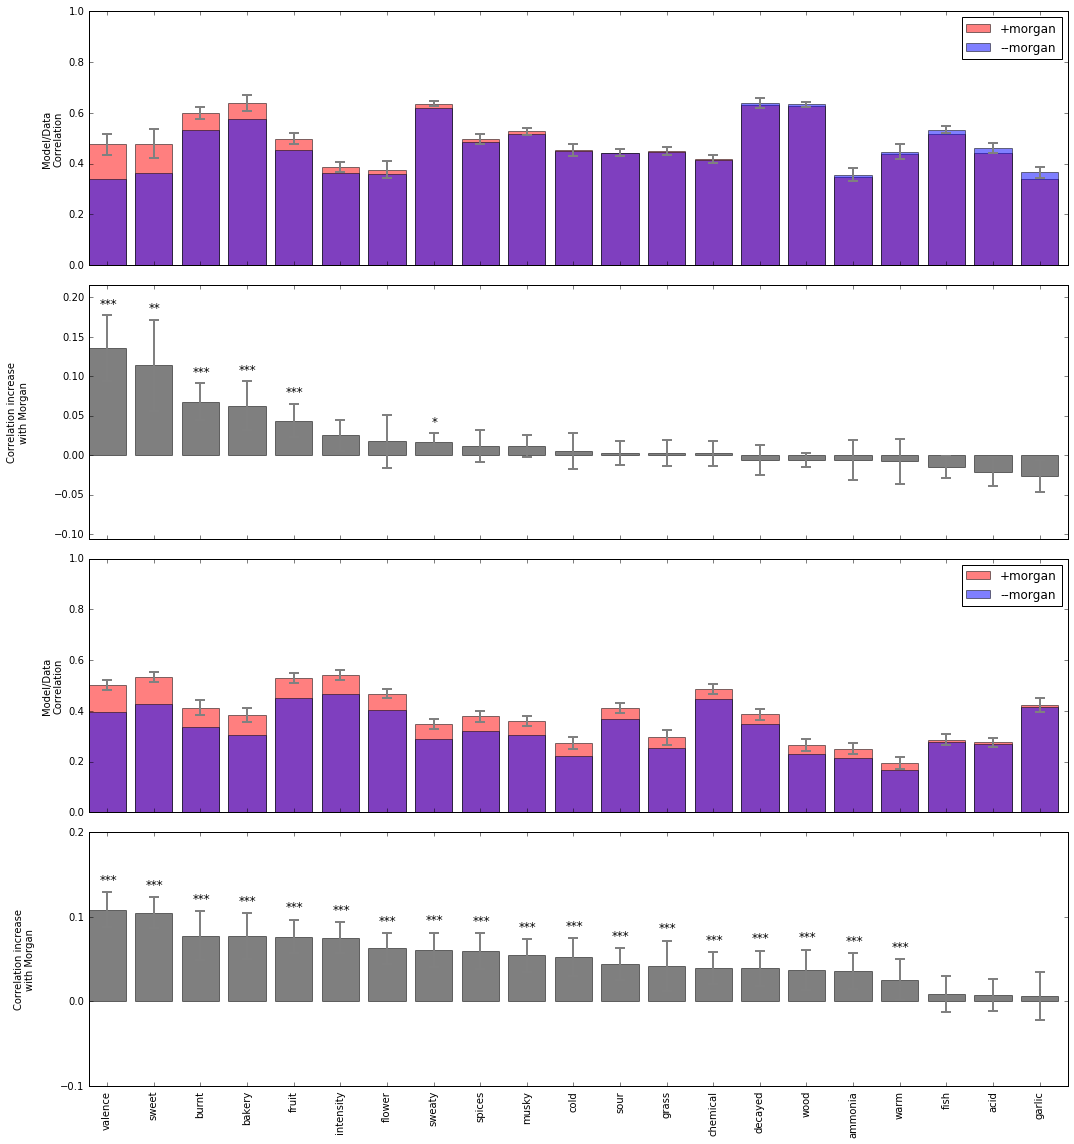

In [747]:
from scipy.stats import ttest_rel

wit = [rs_dec_with_morgan.copy(),rs_lin_with_morgan.copy()]
wout = [rs_dec_without_morgan.copy(),rs_lin_without_morgan.copy()]
diff = [wit[i].mean(axis=1) - wout[i].mean(axis=1) for i in range(2)]
order = [np.argsort(diff[i])[::-1] for i in range(2)]
ts,ps = [np.zeros(21),np.zeros(21)],[np.zeros(21),np.zeros(21)]

# Compute p-values and sort by effect size
for i in range(2):
    for j in range(21):
        ts[i][j],ps[i][j] = ttest_rel(wit[i][j,:],wout[i][j,:])
        ps[i][j] = ps[i][j]*21/(np.argsort(ps[i][j])+1) # FDR correction
    ts[i] = ts[i][order[i]]
    ps[i] = ps[i][order[i]]
    diff[i] = diff[i][order[i]]
    wit[i] = wit[i][order[i],:]
    wout[i] = wout[i][order[i],:]
                                     
fig,ax = plt.subplots(4,1,figsize=(15,16),sharex=True)
yerr = [(wit[i] - wout[i]).std(axis=1)/np.sqrt(n_splits) for i in range(2)]
yerr1 = [[yerr[i][j] if diff[i][j]>=0 else np.nan for j in range(21)] for i in range(2)]
yerr2 = [[yerr[i][j] if diff[i][j]<0 else np.nan for j in range(21)] for i in range(2)]

for i in range(2):
    ax[2*i].bar(np.arange(21),wit[i].mean(axis=1),color='r',yerr=yerr1[i],
          error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2),alpha=0.5,label='+morgan')
    ax[2*i].bar(np.arange(21),wout[i].mean(axis=1),color='b',yerr=yerr2[i],
          error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2),alpha=0.5,label='--morgan')
    ax[2*i+1].bar(np.arange(21),
              diff[i],
              yerr=yerr[i],color='k',#width=0.4,
              error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2),
              alpha=0.5)
    for j in range(21):
        if ps[i][j] < 0.001:
            star = '***'
        elif ps[i][j] < 0.01:
            star = '**'
        elif ps[i][j] < 0.05:
            star = '*'
        else:
            star = ''
        ax[2*i+1].text(j+0.42,diff[i][j]+(-1 if diff[i][j]<0 else 1)*(yerr[i][j]+0.015),star,
                       size=12,horizontalalignment='center',verticalalignment='center')
    ax[2*i].legend(fontsize=12)
    ax[2*i].set_ylim(0,1)
    ax[2*i+1].set_ylim(diff[i].min()-0.08,diff[i].max()+0.08)
    ax[2*i].set_ylabel('Model/Data\nCorrelation')
    ax[2*i+1].set_ylabel('Correlation increase\nwith Morgan')
    ax[2*i+1].yaxis.labelpad = 25
    ax[2*1+1].set_yticks(np.arange(-0.1,0.3,0.1))

for i in range(4):
    ax[i].set_xlim(0,21)
    ax[i].set_xticks(np.arange(21)+0.4)
    ax[i].set_xticklabels([_.split('/')[0].lower() for _ in [descriptors[j] for j in order[int(i/2)]]],rotation=90)
plt.tight_layout()

"""
plt.figure(figsize=(10,10))
plt.errorbar(wout.mean(axis=1),
             wit.mean(axis=1),
             xerr=wout.std(axis=1)/np.sqrt(n_splits),
             yerr=wit.std(axis=1)/np.sqrt(n_splits),
             fmt='o',markersize=0)
for j in range(21):
    plt.text(wout.mean(axis=1)[j],wit.mean(axis=1)[j],letters[j],
             fontdict={'size':14,'weight':'bold'},horizontalalignment='center',verticalalignment='center')
plt.plot([0,1],[0,1],'--')
plt.xlabel('without Morgan')
plt.ylabel('with Morgan');    
""";
plt.savefig('/Users/rgerkin/Desktop/with_without_morgan.eps',format='eps')

## Mean vs Variance

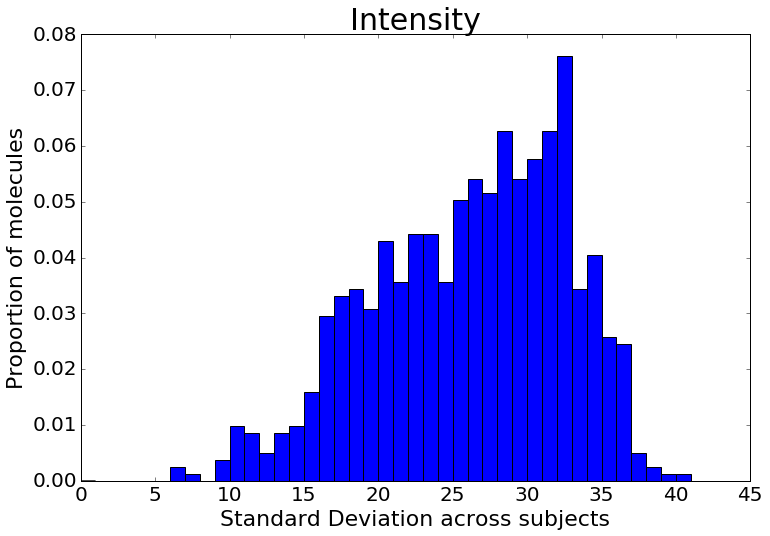

In [86]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.figure(figsize=(12,8))
plt.hist(Y_all['mean_std'][:,0+21],bins=range(0,45,1),normed=True);
plt.xlabel('Standard Deviation across subjects',size=22)
plt.ylabel('Proportion of molecules',size=22)
plt.title('Intensity',size=30)

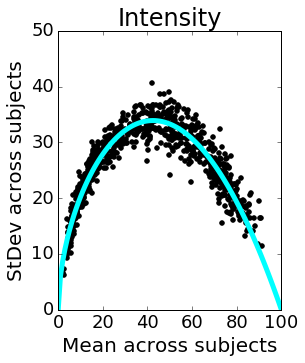

In [93]:
from scipy.optimize import minimize

def f_transformation(x, k0=1.0, k1=1.0):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))

def sse(x, mean, stdev):
    predicted_stdev = f_transformation(mean, k0=x[0], k1=x[1])
    sse = np.sum((predicted_stdev - stdev)**2)
    return sse

plt.figure(figsize=(4,5))
Y_mean = Y_all['mean_std'][:,0]
Y_stdev = Y_all['mean_std'][:,0+21]
plt.scatter(Y_mean,Y_stdev,color='black')
plt.xlabel('Mean across subjects',size=20)
plt.ylabel('StDev across subjects',size=20)
plt.xticks(np.arange(0,101,20),size=18)
plt.yticks(np.arange(0,51,10),size=18)
plt.xlim(0,100)
plt.ylim(0,50)
x = [1.0,1.0]
x_ = np.linspace(0,100,100)
res = minimize(sse, x, args=(Y_mean,Y_stdev), method='L-BFGS-B')
plt.plot(x_,f_transformation(x_, k0=res.x[0], k1=res.x[1]),color='cyan',linewidth=5)
plt.title('Intensity',size=24)

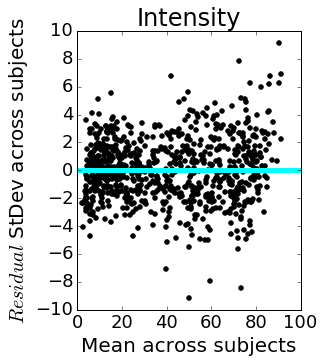

In [120]:
from matplotlib import rc
rc('text', usetex=False)
plt.figure(figsize=(4,5))
plt.scatter(Y_mean,Y_stdev-f_transformation(Y_mean, k0=res.x[0], k1=res.x[1]),color='black')
plt.xlabel(r'Mean across subjects',size=20)
plt.ylabel(r'$Residual$ StDev across subjects',size=20)
plt.xlim(0,100)
plt.ylim(-10,10)
plt.xticks(np.arange(0,101,20),size=18)
plt.yticks(np.arange(-10,11,2),size=18)
plt.plot(x_,[0 for _ in x_],color='cyan',linewidth=5)
plt.title('Intensity',size=24);

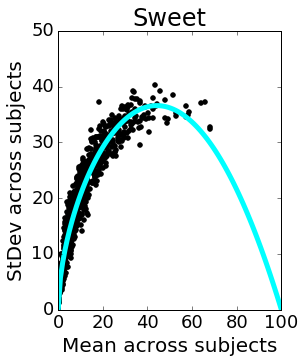

In [125]:
plt.figure(figsize=(4,5))
col = 3
Y_mean = Y_all['mean_std'][:,col]
Y_stdev = Y_all['mean_std'][:,col+21]
plt.scatter(Y_mean,Y_stdev,color='black')
plt.xlabel('Mean across subjects',size=20)
plt.ylabel('StDev across subjects',size=20)
plt.xticks(np.arange(0,101,20),size=18)
plt.yticks(np.arange(0,51,10),size=18)
plt.xlim(0,100)
plt.ylim(0,50)
x = [1.0,1.0]
x_ = np.linspace(0,100,100)
res = minimize(sse, x, args=(Y_mean,Y_stdev), method='L-BFGS-B')
plt.plot(x_,f_transformation(x_, k0=res.x[0], k1=res.x[1]),color='cyan',linewidth=5)
plt.title(descriptors[col][0]+descriptors[col][1:].lower(),size=24)

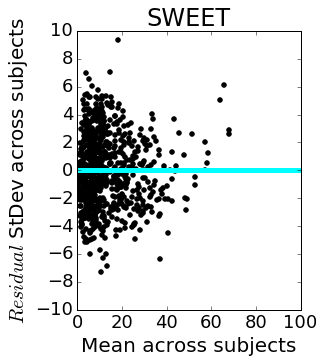

In [124]:
plt.figure(figsize=(4,5))
plt.scatter(Y_mean,Y_stdev-f_transformation(Y_mean, k0=res.x[0], k1=res.x[1]),color='black')
plt.xlabel(r'Mean across subjects',size=20)
plt.ylabel(r'$Residual$ StDev across subjects',size=20)
plt.xlim(0,100)
plt.ylim(-10,10)
plt.xticks(np.arange(0,101,20),size=18)
plt.yticks(np.arange(-10,11,2),size=18)
plt.plot(x_,[0 for _ in x_],color='cyan',linewidth=5)
plt.title(descriptors[col],size=24);

## Subject Clustering

In [7]:
Y,imputer = dream.make_Y_obs(['training','leaderboard','testset'],target_dilution='high',imputer='mask')
y = np.ma.dstack([Y['subject'][i] for i in range(1,50)])
y[y.mask == True] = 0
#y = y.reshape(407*21,49).T

The Y['mean_std'] matrix now has shape (476x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (476x21) molecules by perceptual descriptors, one for each subject


The Y['mean_std'] matrix now has shape (407x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (407x21) molecules by perceptual descriptors, one for each subject


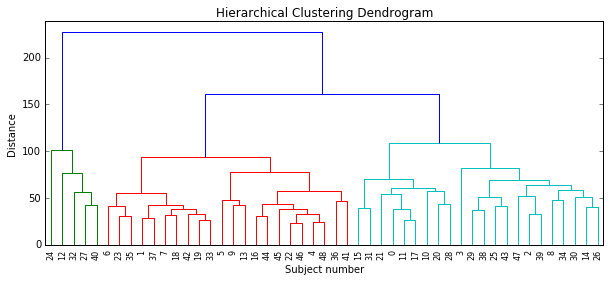

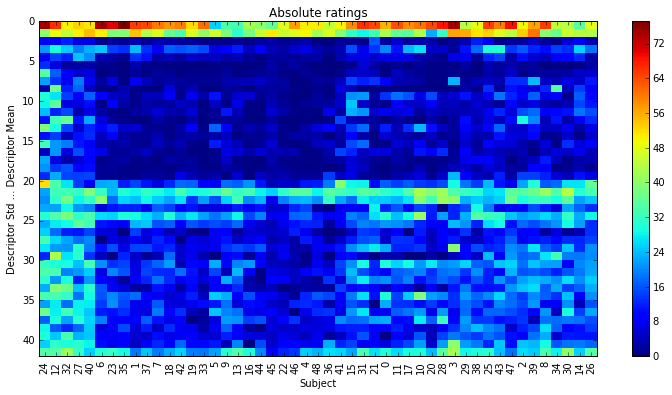

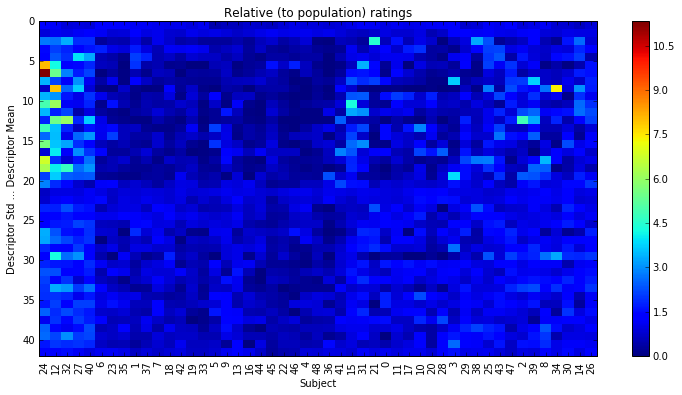

In [8]:
from scipy.cluster.hierarchy import fclusterdata,dendrogram,linkage
Y_gold,_ = dream.make_Y_obs(['training','leaderboard'],target_dilution='high',imputer='mask')
y = np.ma.dstack([Y_gold['subject'][i] for i in range(1,50)])
y = np.vstack((y.mean(axis=0),y.std(axis=0))).T.data
#y = y[:,:23]
#y = y.data / np.mean(y.data,axis=0,keepdims=True)
#print(y.shape)
fclusterdata(y,1)
Z = linkage(y, 'ward')

plt.figure(figsize=(10, 4))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Subject number')
plt.ylabel('Distance')
d = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    distance_sort = 'ascending'
)
plt.show()
y2 = y.copy()
for i in range(49):
    y2[i,:] = y[int(d['ivl'][i]),:]

plt.figure(figsize=(12.5, 6))
plt.pcolor(y2.T)
plt.xlim(0,49);
plt.ylim(42,0);
plt.xlabel('Subject')
plt.xticks(np.arange(49)+0.5,d['ivl'],rotation=90,size=10)
plt.ylabel('Descriptor Std ... Descriptor Mean');
plt.title("Absolute ratings")
plt.colorbar();

plt.figure(figsize=(12.5, 6))
plt.pcolor(y2.T / np.mean(y2.T,axis=1,keepdims=True))
plt.xlim(0,49);
plt.ylim(42,0);
plt.xlabel('Subject')
plt.xticks(np.arange(49)+0.5,d['ivl'],rotation=90,size=10)
plt.ylabel('Descriptor Std ... Descriptor Mean');
plt.title("Relative (to population) ratings")
plt.colorbar();

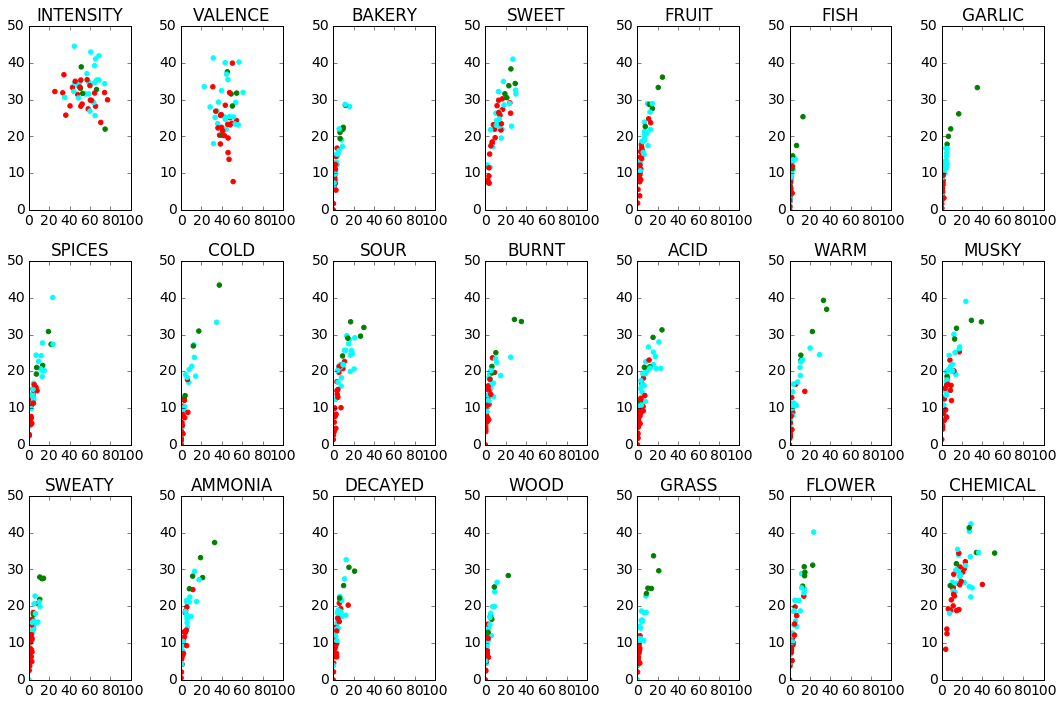

In [12]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
fig,axes = plt.subplots(3,7,figsize=(15,10))
colors = ['k']*49
for i in range(0,5):
    subject = int(d['ivl'][i])
    colors[subject] = 'green'
for i in range(5,27):
    subject = int(d['ivl'][i])
    colors[subject] = 'red'
for i in range(27,49):
    subject = int(d['ivl'][i])
    colors[subject] = 'cyan'
for i,ax in enumerate(axes.flat):
    ax.scatter(y[:,i],y[:,21+i],color=colors)
    ax.set_xlim(0,100)
    ax.set_ylim(0,50)
    ax.set_title(descriptors[i].split('/')[0])
plt.tight_layout()

In [43]:
from scipy.io import matlab
yg = matlab.loadmat('../../data/sc2_yg.mat')
yg = yg['a2']
resort = [sorted([str(i) for i in range(1,50)]).index(str(s)) for s in range(1,50)]
yg = yg[:,resort]
y = np.ma.dstack([Y['subject'][i] for i in range(1,50)])
rg = np.load('../../data/rg.npy')*0.5 + np.load('../../data/sc1_all_rs.npy')*0.5
yg = rg

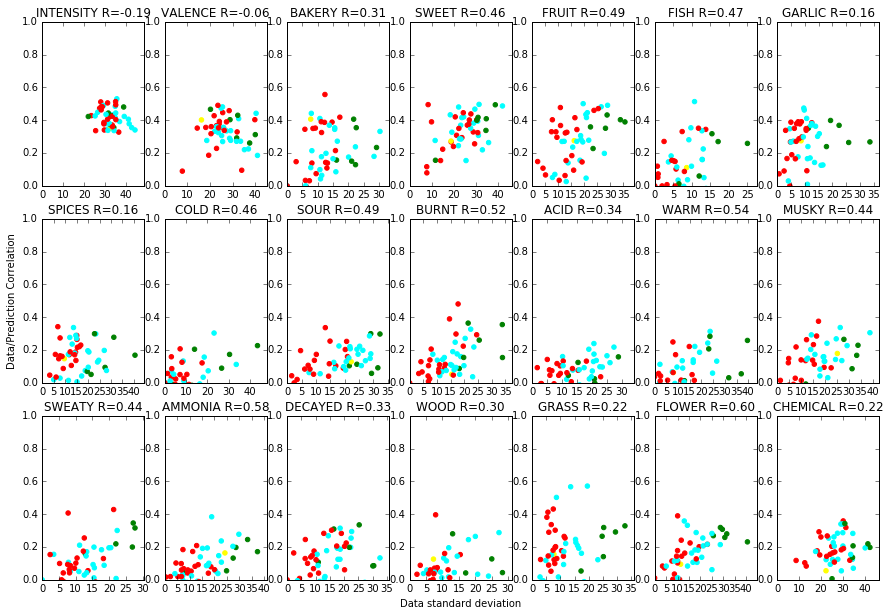

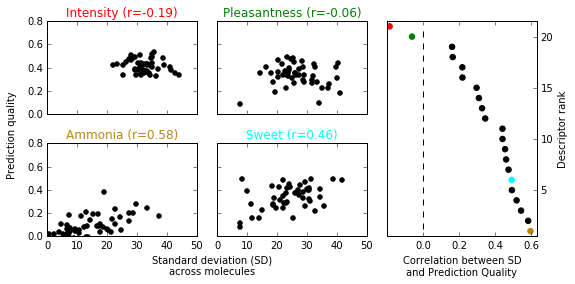

In [45]:
mpl.rcParams.update({'font.size': 10})
rs = np.zeros(21)
fig,axes = plt.subplots(3,7,figsize=(15,10))        
for i,ax in enumerate(axes.flat):
    ax.scatter(y[:,i,:].std(axis=0),yg[i,:],color=colors)
    ax.set_xlim(0,y[:,i,:].std(axis=0).max()*1.1)
    ax.set_ylim(0,1)
    rs[i] = np.ma.corrcoef(y[:,i,:].std(axis=0),yg[i,:])[1,0]
    ax.set_title('%s R=%.2f' % (descriptors[i].split('/')[0],rs[i]))
    if i==7:
        ax.set_ylabel('Data/Prediction Correlation')
    if i==17:
        ax.set_xlabel('Data standard deviation')
   
colors2 = ['k']*21
colors2[20] = 'red'; colors2[0] = 'darkgoldenrod'; colors2[19] = 'green'; colors2[5] = 'cyan'
plt.figure(figsize=(8,4))
ax1 = plt.subplot2grid((2,3), (0, 2), rowspan=2)
ax1.scatter(sorted(rs,reverse=True),np.arange(1,22),marker='o',s=30,color=colors2)
ax1.set_xlim(-0.2,0.63)
ax1.set_ylim(0.5,21.5)
ax1.set_xticks([0,0.2,0.4,0.6])
ax1.plot([0,0],[0,21],'--',color='k')
ax1.set_xlabel('Correlation between SD\nand Prediction Quality')
ax1.set_ylabel('Descriptor rank')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')

ax2 = plt.subplot2grid((2,3), (0, 0))
ax2.scatter(y[:,0,:].std(axis=0),yg[0,:],color='k')
ax2.set_title('Intensity (r=-0.19)',color='red')

ax3 = plt.subplot2grid((2,3), (0, 1))
ax3.scatter(y[:,1,:].std(axis=0),yg[1,:],color='k')
ax3.set_title('Pleasantness (r=-0.06)',color='green')

ax4 = plt.subplot2grid((2,3), (1, 0))
ax4.scatter(y[:,15,:].std(axis=0),yg[15,:],color='k')
ax4.set_title('Ammonia (r=0.58)',color='darkgoldenrod')

ax5 = plt.subplot2grid((2,3), (1, 1))
ax5.scatter(y[:,3,:].std(axis=0),yg[3,:],color='k')
ax5.set_title('Sweet (r=0.46)',color='cyan')        

for ax in [ax2,ax3,ax4,ax5]:
    ax.set_xlim(0,50)
    ax.set_ylim(0,0.75)
    ax.set_yticks([0,0.2,0.4,0.6,0.8])
for ax in [ax2,ax3]:
    ax.set_xticklabels([])
for ax in [ax3,ax5]:
    ax.set_yticklabels([])
    
ax4.set_xlabel('Standard deviation (SD)\nacross molecules')
ax4.set_ylabel('Prediction quality')

plt.tight_layout()
ax4.xaxis.set_label_coords(1.1, -0.2)
ax4.yaxis.set_label_coords(-0.2, 1.1)
plt.savefig('/Users/rgerkin/Desktop/Fig2D.eps',format='eps')

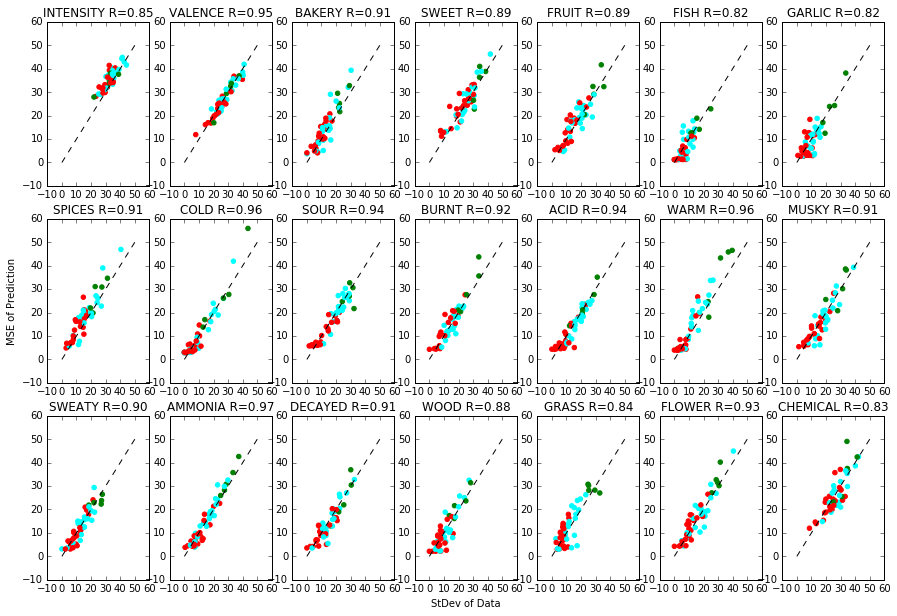

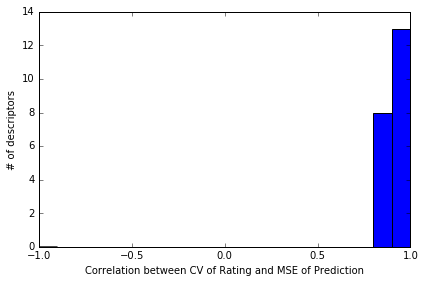

In [15]:
y = np.ma.dstack([Y['subject'][i] for i in range(1,50)])
coe_gs = np.load('../../data/sc1_all_coes.npy')
fig,axes = plt.subplots(3,7,figsize=(15,10))        
for i,ax in enumerate(axes.flat):
    x = y[:,i,:].std(axis=0)#/y[:,i,:].mean(axis=0)
    ax.scatter(x,coe_gs[i,:],color=colors)
    ax.plot([0,50],[0,50],'--',color='k')
    #ax.set_xlim(0,(y[:,i+21]/y[:,i]).max()*1.1)
    #ax.set_ylim(0,1)
    rs[i] = np.ma.corrcoef(x,coe_gs[i,:])[1,0]
    ax.set_title('%s R=%.2f' % (descriptors[i].split('/')[0],rs[i]))
    if i==7:
        ax.set_ylabel('MSE of Prediction')
    if i==17:
        ax.set_xlabel('StDev of Data')

plt.figure()
plt.hist(rs,bins=np.linspace(-1,1,21))
plt.xlabel('Correlation between CV of Rating and MSE of Prediction')
plt.ylabel('# of descriptors')
        
plt.tight_layout()

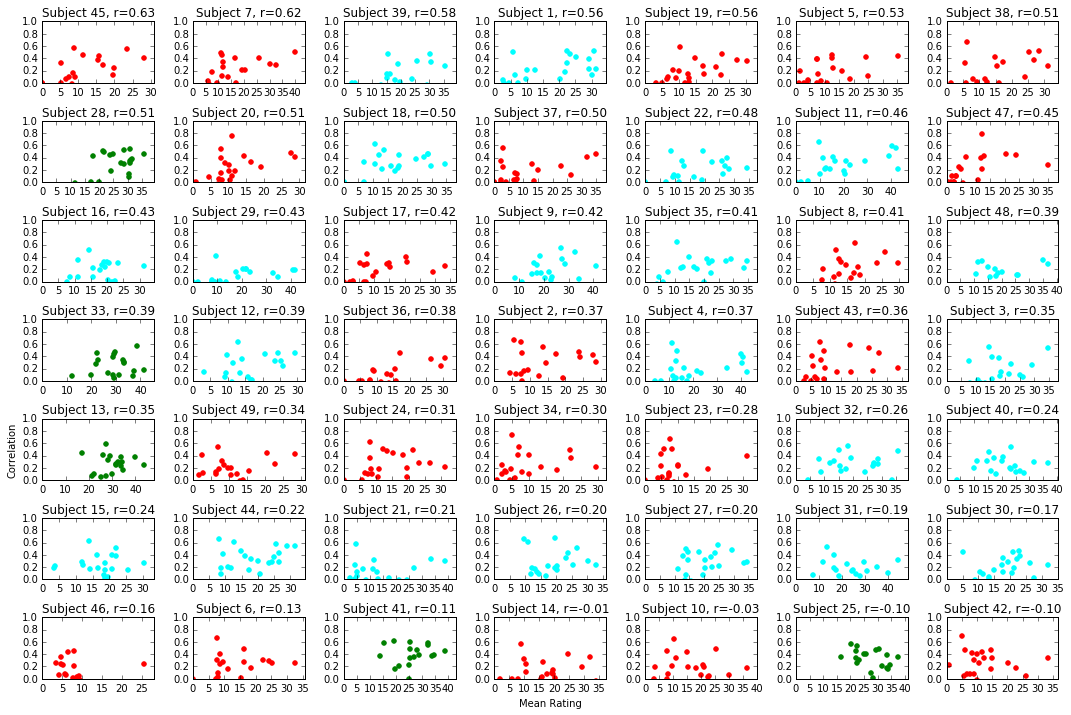

In [16]:
fig,axes = plt.subplots(7,7,figsize=(15,10))
vals = np.arange(0,21)
rs = np.zeros(49)
for i,ax in enumerate(axes.flat):
    rs[i] = np.corrcoef(y[:,vals,i].std(axis=0),yg[vals % 21,i])[0,1]
index = range(49)
index = sorted(index,key=lambda x:rs[x],reverse=True)
for j,ax in enumerate(axes.flat):
    i = index[j]
    ax.scatter(y[:,vals,i].std(axis=0),yg[vals % 21,i],color=colors[i])
    ax.set_xlim(0,y[:,vals,i].std(axis=0).max()*1.1)
    ax.set_ylim(0,1)
    r = np.corrcoef(y[:,vals,i].std(axis=0),yg[vals % 21,i])[0,1]
    ax.set_title('Subject %d, r=%.2f' % (i+1,r))
    if j==45:
        ax.set_xlabel('Mean Rating')
    if j==28:
        ax.set_ylabel('Correlation')
plt.tight_layout()

In [17]:
data = loading.load_data_matrix(gold_standard_only=True, only_replicates=True)
rep_indices = np.where(data[0,:,1,:,0].mean(axis=1).mask == False)[0]
data.shape

(49, 338, 21, 4, 2)

In [18]:
test = data[:,rep_indices,i,:,0].mean(axis=2)
retest = data[:,rep_indices,i,:,1].mean(axis=2)
print(test.shape,retest.shape)
print(np.corrcoef(test[:,0].compressed(),retest[:,0].compressed())[1,0])

IndexError: index 41 is out of bounds for axis 2 with size 21

In [ ]:
rs = np.zeros(21)
fig,axes = plt.subplots(3,7,figsize=(15,10))
for i,ax in enumerate(axes.flat):
    test = data[:,rep_indices,i,:,0].mean(axis=2)
    retest = data[:,rep_indices,i,:,1].mean(axis=2)
    subject_correlations = np.ma.zeros(49)
    subject_correlations.mask = True
    for subject in range(49):
        x = (test[:,subject] - retest[:,subject]).compressed()
        if x.max()>0:
            subject_correlations[subject] = np.sqrt((x**2).mean() - x.mean()**2)/test.mean()
        #subject_correlations[subject] = np.corrcoef(test[:,subject].compressed(),retest[:,subject].compressed())[1,0]
    ax.scatter(subject_correlations,yg[i,:],color=colors)
    ax.set_xlim(0,subject_correlations.max()*1.1)
    ax.set_ylim(0,1)
    rs[i] = np.ma.corrcoef(subject_correlations,yg[i,:])[1,0]
    ax.set_title(descriptors[i].split('/')[0]+' R=%.2f' % rs[i])
    if i==7:
        ax.set_ylabel('Data/Prediction Correlation')
    if i==17:
        ax.set_xlabel('CV')
plt.figure()
plt.hist(rs)
plt.xlabel('Correlation between Test/Retest CV and Prediction Quality')
plt.ylabel('# of descriptors')
plt.tight_layout()

## Figure 5D

In [3]:
corrs = pandas.read_table('../../data/Corr.txt',header=None)
corrs = corrs.as_matrix()
corrs.shape

(69, 69)

In [4]:
corrs_rank = corrs.copy()
for i in range(69):
    sorted_corrs = sorted(corrs[:,i],reverse=True)
    for j in range(69):
        corrs_rank[j,i] = 1+sorted_corrs.index(corrs[j,i])

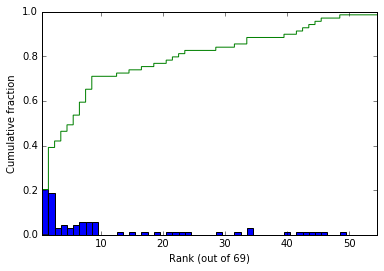

In [5]:
plt.hist(corrs_rank.diagonal(),normed=True,bins=np.arange(0.5,69.5,1));
cumul = plt.hist(corrs_rank.diagonal(),cumulative=True,normed=True,bins=np.arange(0.5,69.5,1),histtype='step')[0];
plt.xlabel('Rank (out of 69)')
plt.ylabel('Cumulative fraction')
plt.xlim(0.5,54.5);

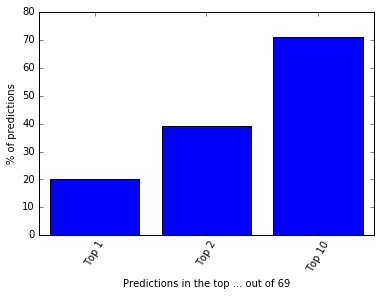

In [6]:
fract_below = [100*cumul[x] for x in [0,1,9]]
cutoffs = np.arange(3)
fig = plt.figure()
ax = fig.gca()
ax.bar(cutoffs,fract_below,align='center')
ax.set_xticks(cutoffs)
ax.set_xticklabels(['Top 1','Top 2','Top 10'],rotation=60)
ax.set_xlabel('Predictions in the top ... out of 69')
ax.set_ylabel('% of predictions');